# PHF

## Dataset

In [15]:
from fetch_dataset import *

dataset, train_loader, val_loader = get_loaders()

Total dataset length: 2480


In [16]:
print("Dataset size: ", len(dataset))
print("Number of batches in train_loader: ", len(train_loader))
print("Number of batches in val_loader: ", len(val_loader))
print("Shape of data in each batch: ", next(iter(train_loader))[0].shape)

Dataset size:  2480
Number of batches in train_loader:  295
Number of batches in val_loader:  16
Shape of data in each batch:  torch.Size([64, 1, 100, 100])


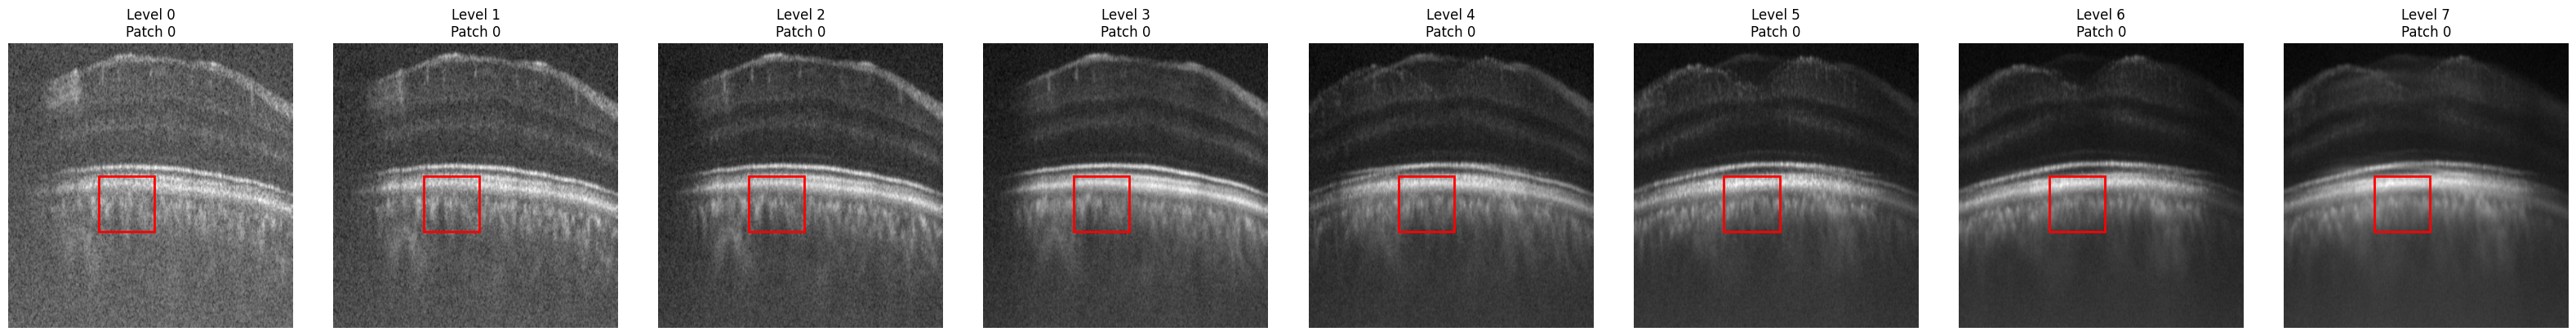

In [17]:
visualize_full_images_with_patches(dataset)

##

## Model

In [18]:
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim
from tqdm import tqdm
import matplotlib.pyplot as plt

class BasicFusionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Simple feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )
        
    def forward(self, x):
        # Input shape: [64, 1, 100, 100]
        features = self.features(x)
        output = self.fusion(features)
        return output

class Visualizer:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        plt.ion()
        
    def update(self, epoch, train_loss, val_loss, input_img, output_img):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        
        plt.figure(figsize=(15, 5))
        
        # Plot losses
        plt.subplot(131)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title(f'Losses (Epoch {epoch+1})')
        plt.legend()
        
        # Plot input image
        plt.subplot(132)
        plt.imshow(input_img.cpu().squeeze().detach().numpy(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        
        # Plot output image
        plt.subplot(133)
        plt.imshow(output_img.cpu().squeeze().detach().numpy(), cmap='gray')
        plt.title('Output Image')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        plt.pause(0.1)
        plt.close()



## Reintroduction of thigns

In [22]:
def fusion_loss(output, target, lambda_edge=0.1, lambda_ssim=0.3):
    """
    Enhanced loss function combining MSE, edge preservation, and structural similarity.
    Simplified for patch-based processing.
    """
    # Basic reconstruction loss
    mse_loss = F.mse_loss(output, target)
    
    # Edge preservation loss using Sobel filters
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                          dtype=torch.float32).view(1, 1, 3, 3).to(output.device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                          dtype=torch.float32).view(1, 1, 3, 3).to(output.device)
    
    # Compute edges
    output_edges_x = F.conv2d(output, sobel_x, padding=1)
    output_edges_y = F.conv2d(output, sobel_y, padding=1)
    target_edges_x = F.conv2d(target, sobel_x, padding=1)
    target_edges_y = F.conv2d(target, sobel_y, padding=1)
    
    edge_loss = F.mse_loss(output_edges_x, target_edges_x) + F.mse_loss(output_edges_y, target_edges_y)
    
    # SSIM loss
    ssim_val = ssim(output, target, data_range=torch.max(target)-torch.min(target), size_average=True)
    ssim_loss = 1 - ssim_val
    
    # Combine losses
    total_loss = mse_loss + lambda_edge * edge_loss + lambda_ssim * ssim_loss
    
    return total_loss

## Training

In [25]:
def train_network(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    visualizer = Visualizer()
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
            inputs = batch[0].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Using only MSE loss to avoid CUDNN issues
            #oss = F.mse_loss(outputs, inputs)
            loss = fusion_loss(outputs, inputs)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                outputs = model(inputs)
                val_loss += F.mse_loss(outputs, inputs).item()
                
                # Save last batch for visualization
                val_inputs = inputs
                val_outputs = outputs
                
        avg_val_loss = val_loss / len(val_loader)
        
        # Update visualization
        visualizer.update(
            epoch,
            avg_train_loss,
            avg_val_loss,
            val_inputs[4],
            val_outputs[4]
        )
        
        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    plt.ioff()
    return model

Epoch 1: 100%|██████████| 295/295 [00:49<00:00,  5.92it/s]


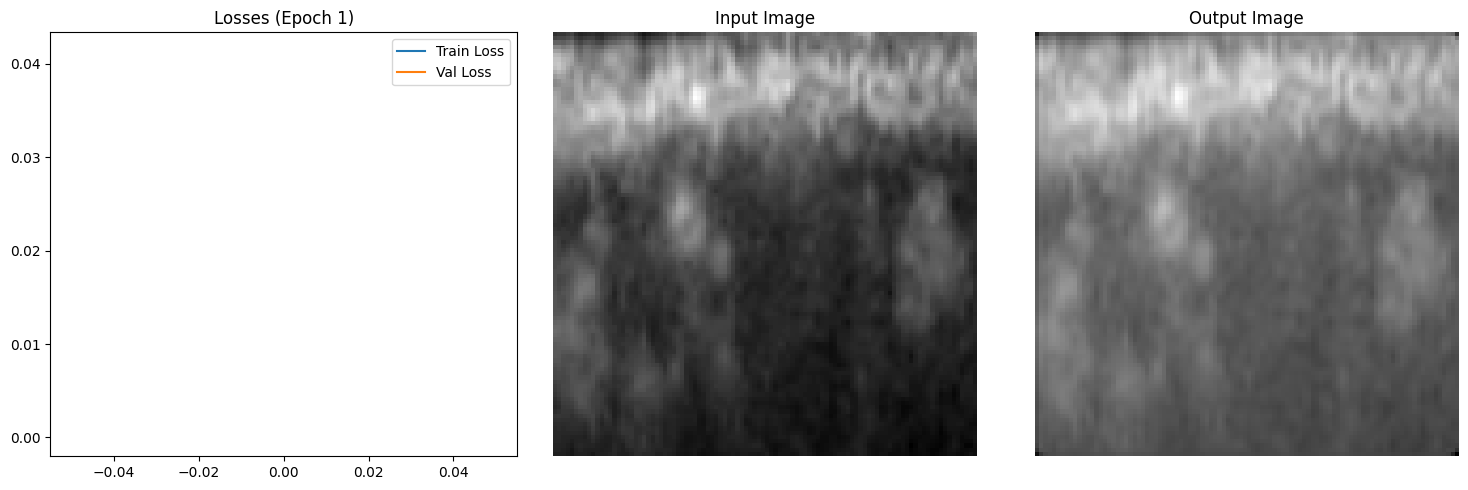

Epoch 1:
Training Loss: 0.0413
Validation Loss: 0.0000


Epoch 2: 100%|██████████| 295/295 [00:49<00:00,  5.90it/s]


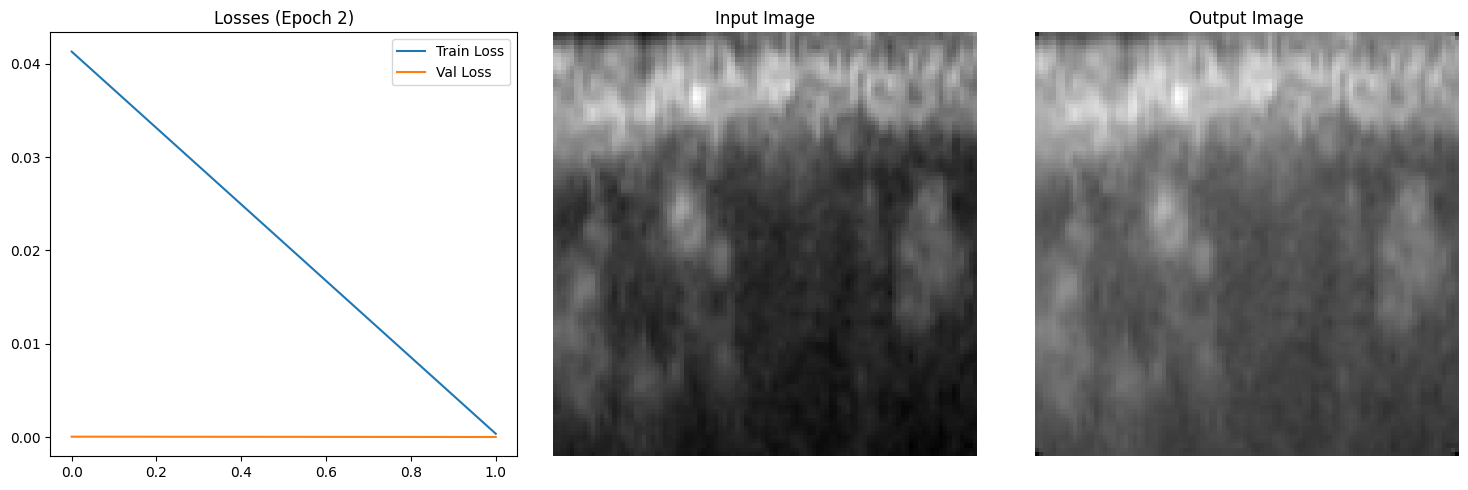

Epoch 2:
Training Loss: 0.0004
Validation Loss: 0.0000


Epoch 3:  38%|███▊      | 111/295 [00:18<00:31,  5.88it/s]


KeyboardInterrupt: 

In [26]:
model = BasicFusionNetwork()
trained_model = train_network(model, train_loader, val_loader, num_epochs=10)

Processing 64 patches
Patch Shape: torch.Size([64, 1, 64, 64])


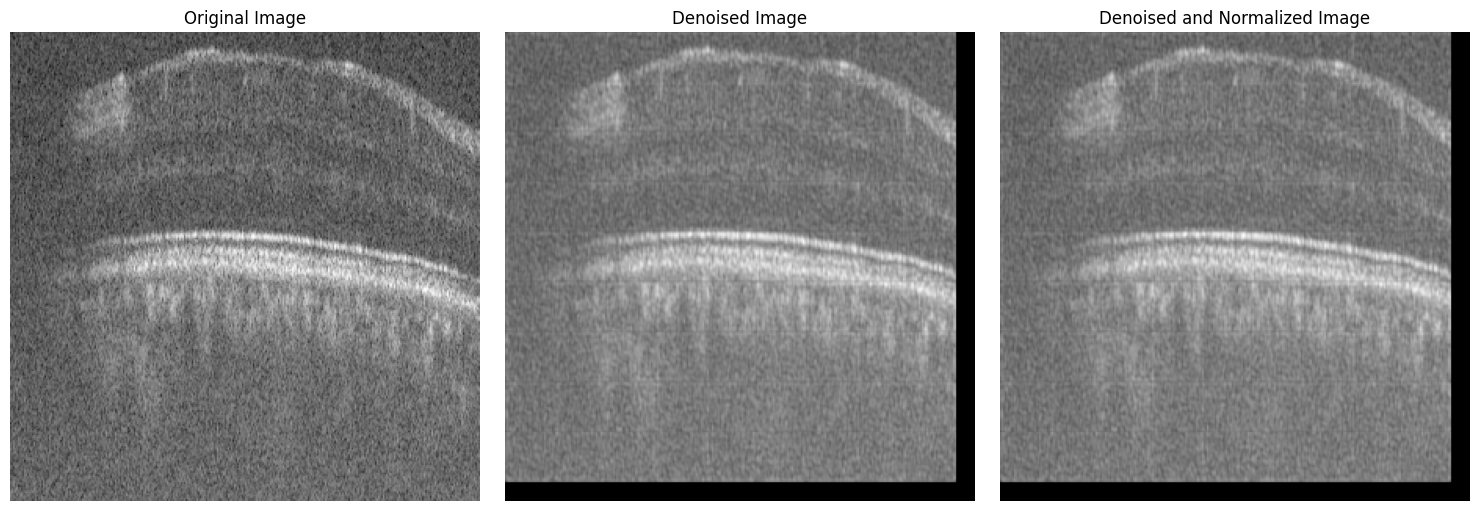

In [21]:
from denoising_full_img import *

denoise(model)